In [71]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

N = 256
X = np.zeros((256,256))

def draw_square(X,s,t,ci,cj):
    
    N = len(X)
    l = int(30/(1+np.exp(-20*(t-0.5)))) + 2 #norm 
    #print(l)
    sint = int(np.ceil(s))
    for i in range(max(ci-sint,0),min(ci+sint,N)):
        if l<8:
            S = int((sint**l - (i - ci)**l)**(1/l))
        else:
            S = sint
        X[i,cj-S:cj+S] = 1
    return X

def define_centers(N,s):
    
    bin_min, bin_max = max(s,0), min(N-s,N)
    ci,cj = np.random.uniform(bin_min,bin_max,size=2)
    return int(ci), int(cj)

def gen_data(X):
    
    N = X.shape[0]
    s = np.random.uniform(N/10,N/3)
    t = np.random.uniform(0,1)
    ci,cj = define_centers(N,s)
    X = draw_square(X,s,t,ci,cj)
    return X


def gen_timeseries(T,M,N):
    X = np.zeros((M,T,N,N))
    t1 = np.random.uniform(size=M) #ending temperatures
    Temperatures = np.array([np.linspace(0,t1[i],T) for i in range(M)]).T
    
    s0,s1 = np.random.uniform(N/10,N/3,size=M), np.random.uniform(N/10,N/3,size=M) #ending sizes
    Sizes = np.array([np.linspace(s0[i],s1[i],T) for i in range(M)]).T#.astype(int)
    
    c0, c1 = np.array([define_centers(N,Sizes[0,i]) for i in range(M)]), np.array([define_centers(N,Sizes[-1,i]) for i in range(M)])
    Centersx, Centersy = np.array([np.linspace(c0[i,0],c1[i,0],T) for i in range(M)]).astype(int), np.array([np.linspace(c0[i,1],c1[i,1],T) for i in range(M)]).astype(int)
    
    for i in tqdm(range(M)):
        for t in range(T):
            X[i,t] = draw_square(X[i,t],Sizes[t,i],Temperatures[t,i],Centersx[i,t],Centersy[i,t])
            
    return X, Centersx, Centersy, Sizes, Temperatures
    
T, M, N = 100, 1000, 28
X, Cx, Cy, S, T = gen_timeseries(T,M,N)

100%|██████████████████████████████████████| 1000/1000 [00:02<00:00, 338.32it/s]


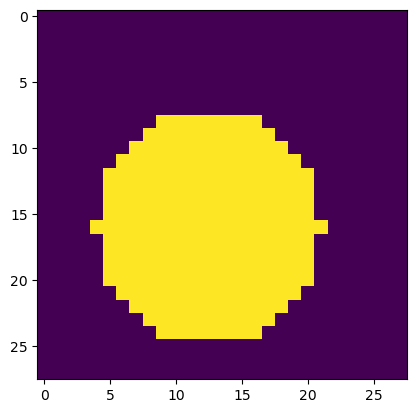

In [76]:
plt.imshow(X[3,0])

In [77]:
import torch
import torchvision.datasets as datasets

device = torch.device('mps')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
from pythae.models import t_AE, t_AEConfig
from pythae.trainers import BaseTrainerConfig
from pythae.pipelines.training import TrainingPipeline
from pythae.models.nn.benchmarks.mnist import Encoder_AE_MNIST, Decoder_AE_MNIST
#from pythae.models.nn import Encoder_vAE

In [80]:
model_config = t_AEConfig(
    input_dim=(1, N, N),
    latent_dim=3
)

model = t_AE(
    model_config=model_config,
    encoder=Encoder_AE_MNIST(model_config), 
    decoder=Decoder_AE_MNIST(model_config) 
)
model = model.to(device)

In [81]:
train_dataset, eval_dataset = X[:-M//10], X[-M//10:]

In [84]:
config = BaseTrainerConfig(
    output_dir='my_model',
    learning_rate=1e-4,
    batch_size=1,
    num_epochs=10, # Change this to train the model a bit more
)

pipeline = TrainingPipeline(
    training_config=config,
    model=model
)

pipeline(
    train_data=train_dataset,
    eval_data=eval_dataset
)

Preprocessing train data...
Preprocessing eval data...

Using Base Trainer



Processor processed data
Processor ade to dataset


Model passed sanity check !

Created my_model/AE_training_2022-12-15_22-06-13. 
Training config, checkpoints and final model will be saved here.

Successfully launched training !



Training of epoch 1/10:   0%|                        | 0/900 [00:00<?, ?batch/s]


Eval of epoch 1/10:   0%|                            | 0/100 [00:00<?, ?batch/s]

Training of epoch 1/10:   0%|                | 1/900 [00:02<34:23,  2.30s/batch]

Training of epoch 1/10:   0%|                | 2/900 [00:04<30:51,  2.06s/batch]

Training of epoch 1/10:   0%|                | 3/900 [00:06<32:13,  2.16s/batch]

KeyboardInterrupt: 